# OctResNet Experiments

Here we train the ResNet-18 network and a ResNet-18 network with Octave Convolution layers on the Tiny ImageNet challenge. We will eventually use the ResNet-50 network. We will eventually compare in terms of both accuracy and compute power expended.

## Setup

In [1]:
import os
import time
import copy

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import transforms, datasets
import OctResNet
%load_ext autoreload
%autoreload 2

In [2]:
# Taken from 231n assignments
USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## Tiny ImageNet Data

We use the Tiny ImageNet database to benchmark some of our results. To download this dataset into your own workspace, run `$ wget http://cs231n.stanford.edu/tiny-imagenet-200.zip` from your command line. Then use the `$ unzip` command to unzip the dataset for use. The data directory should be `tiny-imagenet-200/`.

Information about Tiny ImageNet is located at https://tiny-imagenet.herokuapp.com/.

In [3]:
data_dir = 'tiny-imagenet-200/'

In [4]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print("Number of training examples in dataset: {}".format(len(image_datasets['train'])))
print("Number of validation examples in dataset: {}".format(len(image_datasets['val'])))

Number of training examples in dataset: 100000
Number of validation examples in dataset: 10000


In [5]:
def imshow(inp, title=None):
    """
    Imshow for Tensor.
    
    Code from: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    """
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

Image shape: torch.Size([3, 224, 224])
Image class: 0


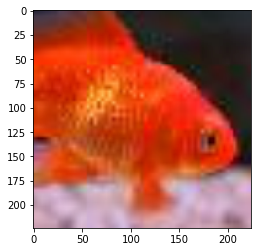

In [6]:
sample = image_datasets['train'][100]
print("Image shape: {}".format(sample[0].shape))
print("Image class: {}".format(sample[1]))
imshow(sample[0])

## Vanilla ResNet-18 Model

Here we load the ResNet-18 model from torchvision.models

## Training ResNet-18

In [7]:
# Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
train_losses = [0]
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_last = 0.0
            running_corrects = 0

            # Iterate over data.
            iter_count = 1
            for inputs, labels in dataloaders[phase]:
#                 print("Iterating over batch of size {}".format(len(inputs)))
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                if iter_count % 50 == 0:
                    time_elapsed = time.time() - since
                    print('Average loss over iteration {} to {} =  {:.4f}'.format(iter_count - 50, iter_count, (running_loss - running_loss_last)/(iter_count*inputs.shape[0])))
                    print('Time elapsed: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
                    train_losses.append((running_loss - running_loss_last)/(iter_count*inputs.shape[0]))
                    running_loss_last = running_loss
                iter_count += 1

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
overfit_losses = []
def overfit_model(model, criterion, optimizer, num_batches=2000, batch_size=4, scheduler=None, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #Collect small dataset
    overfit_target = []
    batch_count = 0
    for inputs, labels in dataloaders['train']:
#                 print("Iterating over batch of size {}".format(len(inputs)))
        overfit_target.append((inputs, labels))
        batch_count += 1
        if batch_count == num_batches:
            break
    
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                if scheduler:
                    scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in overfit_target:

                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / (num_batches*batch_size)
            overfit_losses.append(epoch_loss)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [30]:
octresnet18 = OctResNet.tinyoctresnet18(pretrained=False, progress=True).to(device)

In [36]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(octresnet18.parameters(), lr=learning_rate)
overfit_losses = []
overfit_model(octresnet18, loss_fn, optimizer, num_batches=100, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0403 Acc: 0.0075
Epoch 1/29
----------
train Loss: 0.0258 Acc: 0.0025
Epoch 2/29
----------
train Loss: 0.0217 Acc: 0.0100
Epoch 3/29
----------
train Loss: 0.0202 Acc: 0.0300
Epoch 4/29
----------
train Loss: 0.0192 Acc: 0.0525
Epoch 5/29
----------
train Loss: 0.0181 Acc: 0.0900
Epoch 6/29
----------
train Loss: 0.0171 Acc: 0.1175
Epoch 7/29
----------
train Loss: 0.0159 Acc: 0.1725
Epoch 8/29
----------
train Loss: 0.0147 Acc: 0.2250
Epoch 9/29
----------
train Loss: 0.0134 Acc: 0.2875
Epoch 10/29
----------
train Loss: 0.0120 Acc: 0.3725
Epoch 11/29
----------
train Loss: 0.0106 Acc: 0.4750
Epoch 12/29
----------
train Loss: 0.0092 Acc: 0.5350
Epoch 13/29
----------
train Loss: 0.0078 Acc: 0.6225
Epoch 14/29
----------
train Loss: 0.0066 Acc: 0.6775
Epoch 15/29
----------
train Loss: 0.0054 Acc: 0.7475
Epoch 16/29
----------
train Loss: 0.0043 Acc: 0.8250
Epoch 17/29
----------
train Loss: 0.0035 Acc: 0.8525
Epoch 18/29
----------
train Loss: 0.0

OctaveResNet(
  (conv1): OctConv2dStackable(
    (conv_hh): Conv2d(3, 48, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (conv_hl): Conv2d(3, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (pool): AvgPool2d(kernel_size=(2, 2), stride=2, padding=0)
  )
  (bnLow): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bnHigh): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1bn): OctConv2dBN(
        (conv_hh): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_ll): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv_lh): Conv2d(16, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (upsample): Upsample(scale_factor=2.0, mode=nearest)
        (conv_hl): Conv2d(48, 16, kernel_s

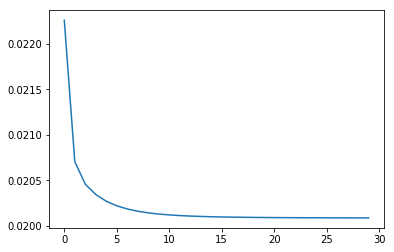

In [35]:
plt.plot(overfit_losses)
plt.show()
overfit_losses_stored = [overfit_losses.copy()]

In [25]:
resnet18 = torchvision.models.resnet18(pretrained=False).to(device)

In [27]:
loss_fn = nn.CrossEntropyLoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(resnet18.parameters(), lr=learning_rate)
overfit_losses = []
overfit_model(resnet18, loss_fn, optimizer, num_batches=100, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0265 Acc: 0.0050
Epoch 1/29
----------
train Loss: 0.0197 Acc: 0.0450
Epoch 2/29
----------
train Loss: 0.0163 Acc: 0.1750
Epoch 3/29
----------
train Loss: 0.0139 Acc: 0.3475
Epoch 4/29
----------
train Loss: 0.0124 Acc: 0.4575
Epoch 5/29
----------
train Loss: 0.0112 Acc: 0.5400
Epoch 6/29
----------
train Loss: 0.0100 Acc: 0.6625
Epoch 7/29
----------
train Loss: 0.0084 Acc: 0.8175
Epoch 8/29
----------
train Loss: 0.0070 Acc: 0.8900
Epoch 9/29
----------
train Loss: 0.0055 Acc: 0.9800
Epoch 10/29
----------
train Loss: 0.0041 Acc: 1.0000
Epoch 11/29
----------
train Loss: 0.0030 Acc: 0.9975
Epoch 12/29
----------
train Loss: 0.0021 Acc: 1.0000
Epoch 13/29
----------
train Loss: 0.0015 Acc: 1.0000
Epoch 14/29
----------
train Loss: 0.0011 Acc: 1.0000
Epoch 15/29
----------
train Loss: 0.0008 Acc: 1.0000
Epoch 16/29
----------
train Loss: 0.0006 Acc: 1.0000
Epoch 17/29
----------
train Loss: 0.0005 Acc: 1.0000
Epoch 18/29
----------
train Loss: 0.0

KeyboardInterrupt: 

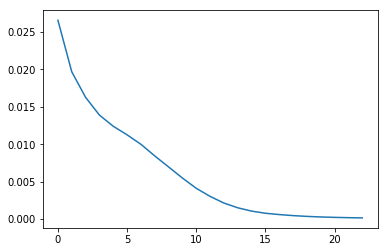

In [28]:
plt.plot(overfit_losses)
plt.show()
overfit_losses_stored = [overfit_losses.copy()]

In [24]:
#Save model?
torch.save(resnet18.state_dict(), './best_oct_model.wts')

NameError: name 'model' is not defined

In [27]:
print(torch.cuda.max_memory_allocated(device))
print(torch.cuda.get_device_capability(device))

1190210048
(3, 7)
